# Geodesics in Quantum computing for optimization.

First we are going to define the distance notions utilized for this work:

Fubini-Studi Distance:

$$
 d_{\text{FS}}(\rho_\psi, \sigma_ \phi) = \inf \limits_{||\psi_\theta||=||\phi_\delta||=1} ||\ket{\psi_\theta}-\ket{\phi_\delta}|| \\
    = \sqrt{2-2|\braket{\psi}{\phi}|}
$$

Bures Distance:

$$
d_B (\rho , \sigma ) = \sqrt{2 - 2 F(\rho, \sigma)}
$$
where $F(\rho, \sigma ) = \left\| \sqrt{\rho} \sqrt{\sigma} \right\|_1 = \text{tr}(\sqrt{\sqrt{\sigma} \rho \sqrt{\sigma}})$ is the Uhlmann fidelity of two quantum states

Geodesic length $\theta$ at the pure state space $\mathcal{S_H}$:

$$
\theta = \arccos{\Re \braket{\psi|\phi}}
$$


Geodesic length $\theta$ at the projective space $P \mathcal{H}$:

$$
\theta = \arccos{|\bra{\psi}\ket{\phi}|}
$$



In [3]:
import numpy as np
from scipy.linalg import eigh

def FS_distance(psi : np.array, phi : np.array) -> float:
    """
    Computes the distance between two states using the Fubini-Study metric.
    psi: np.array is a state vector with complex entries
    phi: np.array is a state vector also with complex entries

    return:
    d_FS: float, the distance between the two states
    given by the Fubini-Study Metric
    """

    # Compute the inner product
    abs_inner_product = np.abs(np.vdot(psi, phi)) 

    # Compute the Fubini-Study distance
    d_FS = np.sqrt(2 - 2 * abs_inner_product)
    return d_FS


def sqrtm_positive_semidefinite(matrix, tol=1e-10):
    # Diagonaliza la matriz hermítica
    eigvals, eigvecs = eigh(matrix)

    # Corrige pequeños errores numéricos
    eigvals[np.abs(eigvals) < tol] = 0

    if np.any(eigvals < 0):
        raise ValueError("Matrix has negative eigenvalues; square root is not defined in reals")

    sqrt_eigvals = np.sqrt(eigvals)
    sqrt_matrix = eigvecs @ np.diag(sqrt_eigvals) @ eigvecs.conj().T
    return sqrt_matrix

def fidelity(rho : np.array, sigma : np.array) -> float:
    """
    Computes the fidelity between two quantum states.
    rho: np.array is the density matrix of the first state
    sigma: np.array is the density matrix of the second state
    return:
    F: float, the fidelity between the two states
    """

    sqrt_sigma = sqrtm_positive_semidefinite(sigma)
    traced_term = sqrtm_positive_semidefinite(sqrt_sigma @ rho @ sqrt_sigma)

    return np.trace(traced_term) ** 2


def Bures_distance(rho : np.array, sigma : np.array) -> float:
    """
    Computes the distance between two states using the Bures metric.
    psi: np.array is the density matrix of the first state
    phi: np.array is the density matrix of the second state

    return:
    d_Bures: float, the distance between the two states
    given by the Bures Metric
    """

    # Compute the inner product

    # Compute the Bures distance
    F = fidelity(rho, sigma)
    d_Bures = np.sqrt(2 - 2 * np.sqrt(F)) 
    return d_Bures



## Geodesic over pure states:


The geodesic on $(\mathcal{S_H},\Re \braket{ \cdot })$, i.e. in the pure state space, are given by:

\begin{equation}
    \Gamma_g(\tau) = \cos \tau \ket{\psi} + \sin \tau \ket{\dot{\psi}}
\end{equation}
with $0\leq\tau\leq\theta$, where $\theta = \arccos(\Re\braket{\psi}{\phi})$ is the geodesic distance between the starting point. (The reason why it depends on the phase is because the tangent space associated to the point of a representative of the classes, up to a global phase does depend on it.) $\ket{\psi}$ and the ending point $\ket{\phi} = \cos{\theta} \ket{\psi} + \sin \theta \ket{\dot{\psi}}$

From this last expression, we can express $\ket{\dot{\psi}}$ as:

\begin{equation}
    \ket{\dot{\psi}}= \frac{1}{\sin \theta} \bigg ( \ket{\phi} - \cos{\theta} \ket{\psi} \bigg )
\end{equation}

useful to gain intuition, but it is not valid for all of our work, because is not the projective space and more precisely, it is not invariant up to a global phase.

In [4]:
def SH_geodesic_length(psi : np.array, phi : np.array) -> float:
    """
    Computes the geodesic distance between two pure states. Recall that
    the geodesic length is given by theta = Arccos(Re{< ψ | φ >}) 
        psi: np.array is a state vector
        phi: np.array is a state vector
    return:
    theta: float, the geodesic lenght between the two states
    """
    # Compute the real part of the inner product
    re_inner_prod = np.real(np.vdot(psi, phi)) 

    # Compute the geodesic length
    theta = np.arccos(re_inner_prod)
    return theta


def SH_psi_dot(psi : np.array, phi : np.array) -> np.array:
    """
    Computes the tangent/velocity statevector at the projective space
    psi: np.array is the initial state vector
    phi: np.array is the final state vector

    return:
    psi_dot: np.array 
    
    tangent vector between the two states. this has the property of being 
    constant if travelling from the geodesic by construction
    """
    theta = SH_geodesic_length(psi, phi)
    sin_theta, cos_theta = np.sin(theta), np.cos(theta)
    psi_dot = ( phi - cos_theta * psi ) / sin_theta
    return psi_dot


def SH_geodesic(psi : np.array, phi : np.array, tau : float) -> np.array:
    """
    Computes the geodesic point between two states psi and phi given the time tau
    psi: np.array is a state vector
    phi: np.array is a state vector
    tau: float, parameter of the geodesic

    return:
    psi_tau: np.array, the geodesic state at parameter tau
    """

    # Compute the inner product

    sin_tau, cos_tau = np.sin(tau), np.cos(tau)
    psi_dot_geo = SH_psi_dot(psi, phi)

    return cos_tau * psi + sin_tau * psi_dot_geo




We recall that this definition is valid on the space of pure states $\mathcal{S_H}$. The geodesic expression for the projective space $P\mathcal{H}$ is given by:

\begin{equation}
    \gamma_{g, \pm}(\tau) = \ket{\psi_{g,\pm}(\tau)} \bra{\psi_{g,\pm}(\tau)}
\end{equation}

Where 

\begin{align}
    \ket{\psi_{g,\pm}(\tau)} 
    = \frac{1}{\sin(\theta_\pm)} \Big( 
        & \sin(\theta_\pm - \tau) \ket{\psi} \nonumber \\
        & \pm \sin(\tau) e^{-i \arg \braket{\psi}{\phi_0}} \ket{\phi_0} 
    \Big)
\end{align}

and $\theta_+ = \arccos{|\braket{\psi | \phi_0}|}$ and $\theta_- = \pi - \theta_+$ and $\ket{\phi} = \ket{\phi_\pm} = \pm e^{-i \arg\braket{\psi}{\phi_0}} \ket{\phi_0}$ and $\ket{\phi_0} \in \pi^{-1} (\sigma_\phi) = \{ e^{i\theta} \ket{\phi}; 0 \leq \theta < 2  \pi \}$

notar que tenemos que encontrar el estado $\ket{\psi_0}$ tal que cumpla la cond de ortonormalidad!!

In [5]:
from typing import Tuple


def PH_geodesic_length(psi : np.array, phi : np.array) -> float:
    """
    Computes the geodesic distance between two mixed states. Recall that
    the geodesic length is given by theta = Arccos(|< ψ | φ >|) 
        ψ : np.array is the density matrix of the first state
        φ : np.array is the density matrix of the second state
    return:
    theta: float, the geodesic lenght between the two states
    """
    # Compute the real part of the inner product
    abs_inner_prod = np.abs(np.vdot(psi, phi))

    # Compute the geodesic length
    theta = np.arccos(abs_inner_prod)
    return theta


def find_alpha(t: float, z: complex) -> float:
    """
    Encuentra el valor de alpha en [0, 2π) tal que exp(i alpha) = cos(t)/z

    Parámetros:
    -----------
    t : float
        Ángulo real conocido.
    z : complex
        Número complejo.

    Retorna:
    --------
    alpha : float
        Ángulo en radianes en el intervalo [0, 2π).
    """
    cos_t = np.cos(t)
    rhs = cos_t / z
    alpha = np.angle(rhs) % (2 * np.pi)
    return alpha



def PH_psi_dot(psi: np.array, phi: np.array) -> Tuple[np.array, bool]:
    """
    Computes the tangent/velocity statevector at the projective space
    psi: np.array is the initial state vector
    phi: np.array is the final state vector

    return:
    psi_dot: np.array 
    
    tangent vector between the two states. this has the property of being 
    constant if travelling from the geodesic by construction
    """
    #TO DO: Need to improve this function

    psi_dot_candidate = SH_psi_dot(psi, phi)
    horizontal_cond_one = np.allclose(np.vdot(psi_dot_candidate, psi), 0) #Check if this is Re{...}

    if horizontal_cond_one:
        return psi_dot_candidate, horizontal_cond_one
    

    else:
        theta_angle = PH_geodesic_length(psi, phi)
        alpha = find_alpha(theta_angle, np.vdot(psi, phi))
        new_phi = np.exp(1j * alpha) * phi
        
        psi_dot_candidate = SH_psi_dot(psi, new_phi)
        horizontal_cond = np.allclose(np.vdot(psi_dot_candidate, psi), 0)
        return new_phi, horizontal_cond_one
        
        
        raise ValueError("The tangent vector is not orthogonal to the state vector.")



def PH_geodesic(psi: np.array, phi: np.array, tau: float) -> np.array:
    """
    Computes the geodesic between two density matrices `psi` and `phi`.
    Raises ValueError if a valid tangent vector cannot be constructed.

    psi : np.array (pure state vector)
    phi : np.array (pure state vector)
    tau : float, interpolation parameter

    Returns
    -------
    np.array : Density matrix at parameter tau along the geodesic.
    """
    theta_plus = PH_geodesic_length(psi, phi)

    # Will raise ValueError if the vector is not orthogonal
    psi_dot, hor_cond = PH_psi_dot(psi, phi)  

    sin_theta = np.sin(theta_plus)
    sin_theta_tau = np.sin(theta_plus - tau)
    sin_tau = np.sin(tau)

    if hor_cond:
        ket = (1 / sin_theta) * (
            sin_theta_tau * psi + sin_tau * np.exp(-1j * np.angle(np.vdot(psi, phi))) * phi
        )
        
    else:
        ket = (1 / sin_theta) * (
            sin_theta_tau * psi + sin_tau * np.exp(-1j * np.angle(np.vdot(psi, psi_dot))) * psi_dot
        )

    return np.outer(ket, ket.conj())





## 1 qubit case:

Let's consider the geodesic path travelled between the quantum states $\ket{0}$ and the states $\ket{+}$.

First, lets compute analitaclly some properties of this system:

1) The geodesic lenght between $\theta (\ket{0}, \ket{+}) = 0.7853... = \pi/4$
2) $d_{FS} = \sqrt{2 - 2 |<0|+>|} = \sqrt{2 - \sqrt{2}} = 0.76537..$
3) $2 \sin{\theta / 2} = d_{FS}$

and let's compare it with our code:

In [37]:
ket_zero = np.array([1, 0])
ket_one = np.array([0, 1])
ket_plus = (ket_zero + ket_one) / np.sqrt(2)

PH_geo_length_zero_plus = PH_geodesic_length(ket_zero, ket_plus)


arb_phase = np.exp(1j * np.random.uniform(0, 2 * np.pi))
random_plus = arb_phase * ket_plus

# I did this to see if our geodesic is really invariant under global phase
geodesic_curve_onequbit = [ PH_geodesic(ket_zero, random_plus, tau) 
                           for tau in np.linspace(0, PH_geo_length_zero_plus, 100)]



print(f'Geodesic lenght between |0> and |+> = {PH_geodesic_length(ket_zero, ket_plus):.5f}... ')
print(f'Fubini-Study distance between |0> and |+> = {FS_distance(ket_zero, ket_plus):.5f}... ')
print(f'2 sin(theta/2) = {2 * np.sin(PH_geo_length_zero_plus / 2):.5f}... ')



Geodesic lenght between |0> and |+> = 0.78540... 
Fubini-Study distance between |0> and |+> = 0.76537... 
2 sin(theta/2) = 0.76537... 



Analytically, the tangent vector between these two points is $\ket{\dot{\psi}} = \ket{1}$.

\begin{equation}
    \Gamma (\tau) = \cos(\tau) \ket{0} + \sin(\tau) \ket{1}
\end{equation}

In [7]:
PH_psi_dot(ket_zero, ket_plus) #efectivamente el vector tangente es \ket{1}
#PH_psi_dot(ket_zero, random_plus) #efectivamente el vector tangente es \ket{1}

(array([0., 1.]), True)

Por ultimo, podemos graficar esto en la esfera de Bloch:

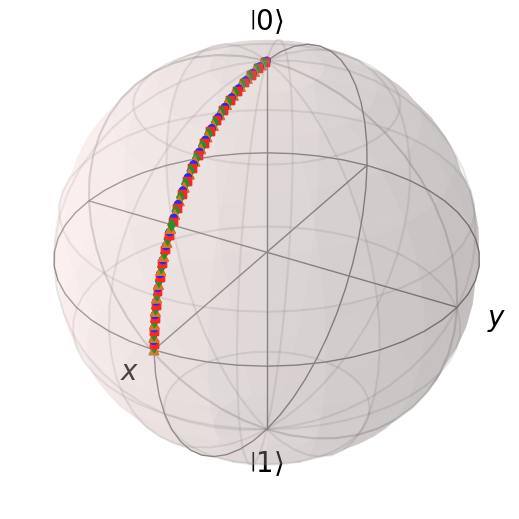

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch, Qobj, sigmax, sigmay, sigmaz

# Nota: Esto fue hecho por ChatGPT y no es parte de la tarea original

def density_to_bloch_vector(rho):
    """
    Convierte una matriz densidad 2x2 en su vector de Bloch.

    Parámetros:
    -----------
    rho : np.array
        Matriz densidad 2x2.

    Retorna:
    --------
    list of float: [x, y, z] coordenadas en la esfera de Bloch.
    """
    rho_qobj = Qobj(rho)
    x = np.real((rho_qobj * sigmax()).tr())
    y = np.real((rho_qobj * sigmay()).tr())
    z = np.real((rho_qobj * sigmaz()).tr())
    return [x, y, z]

def plot_density_matrices_on_bloch(rho_list):
    """
    Grafica una lista de matrices densidad 2x2 en la esfera de Bloch.

    Parámetros:
    -----------
    rho_list : list of np.array
        Lista de matrices densidad 2x2.
    """
    b = Bloch()
    b.vector_color = ['r'] * len(rho_list)  # Puntos rojos
    for rho in rho_list:
        bloch_vec = density_to_bloch_vector(rho)
        b.add_points(bloch_vec)
    b.show()

"""
# 🎯 Ejemplo de uso
rho_0 = np.array([[1, 0], [0, 0]])  # |0⟩
rho_1 = np.array([[0, 0], [0, 1]])  # |1⟩
rho_plus = 0.5 * np.array([[1, 1], [1, 1]])  # |+⟩
rho_minus = 0.5 * np.array([[1, -1], [-1, 1]])  # |−⟩
rho_y = 0.5 * np.array([[1, -1j], [1j, 1]])  # |i⟩

lista = [rho_0, rho_1, rho_plus, rho_minus, rho_y]
plot_density_matrices_on_bloch(lista)
"""
plot_density_matrices_on_bloch(geodesic_curve_onequbit)


## Two qubit case:

Distancia mid circuit we define

$$
\ket{\psi}_{\text{mid}} = (H \otimes I) \ket{00}
$$

the middle circuit state in which we reach the state. We are going to compute the distance between this state and the curve of the geodesic.



In [9]:
ket_pluszero = np.kron(ket_plus, ket_zero)
ket_zerozero = np.kron(ket_zero, ket_zero)
ket_bell = np.array([1, 0, 0, 1]) / np.sqrt(2)

PH_geo_length_zz_bell = PH_geodesic_length(ket_zerozero, ket_bell)

print("📏 Comparación de distancias entre |00⟩ y |Φ⁺⟩\n")
print(f"{'Magnitud':<45} {'Valor'}")
print(f"{'-'*60}")
print(f"{'Longitud geodésica total':<45} {PH_geo_length_zz_bell:.10f}")
print(f"{'Distancia de Fubini-Study':<45} {FS_distance(ket_zerozero, ket_bell):.10f}")
print(f"{'2·sin(θ/2)':<45} {2 * np.sin(PH_geo_length_zz_bell / 2):.10f}\n")

geodesic_curve_zz_bell = [ PH_geodesic(ket_zerozero, ket_bell, tau) 
                           for tau in np.linspace(0, PH_geo_length_zz_bell, 100)]

#d_FS between the geodesic points and the |+0> state.
#its okay bcs we are working with pure states
d_FS_zeroplus_geodesic = np.real(np.array([Bures_distance(Gamma_tau_start, np.outer(ket_pluszero, ket_pluszero.conj())) 
                                   for Gamma_tau_start in geodesic_curve_zz_bell]))
                                

# Convertir a numpy array solo por optimizarlo
arr = d_FS_zeroplus_geodesic

# Encontrar el valor máximo, mínimo y sus índices
max_val = np.max(arr)
max_index = np.argmax(arr)
max_tau = np.linspace(0, PH_geo_length_zz_bell, 100)[max_index]

min_val = np.min(arr)
min_index = np.argmin(arr)
min_tau = np.linspace(0, PH_geo_length_zz_bell, 100)[min_index]


print("📐 Distancia de Fubini-Study entre |+0⟩ y la curva geodésica\n")
print(f"{'Estadística':<10} {'Valor':<20} {'Índice':<10} {'Tau'}")
print(f"{'-'*60}")
print(f"{'Máximo':<10} {max_val:<20.10f} {max_index:<10} {max_tau:.5f}")
print(f"{'Mínimo':<10} {min_val:<20.10f} {min_index:<10} {min_tau:.5f}\n")


📏 Comparación de distancias entre |00⟩ y |Φ⁺⟩

Magnitud                                      Valor
------------------------------------------------------------
Longitud geodésica total                      0.7853981634
Distancia de Fubini-Study                     0.7653668647
2·sin(θ/2)                                    0.7653668647

📐 Distancia de Fubini-Study entre |+0⟩ y la curva geodésica

Estadística Valor                Índice     Tau
------------------------------------------------------------
Máximo     1.0000000000         99         0.78540
Mínimo     0.7653668647         0          0.00000



## How IBM compute this states:

The quantum circuit of the bell state is 

$$
\ket{\Phi^+} = \text{CNOT}_{q_0 \to q_1} (H \otimes I) \ket{00}
$$

We are going to see how ibm is implementing this

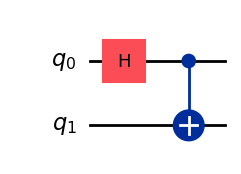

In [10]:
#okay, lets try now how it is implemented in a real quantum computer
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import Statevector, DensityMatrix

# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
qc.cx(0, 1)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
#qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.

qc.draw('mpl')

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.backend('ibm_sherbrooke')
print(f'Using backend: {backend.name}')

Using backend: ibm_sherbrooke


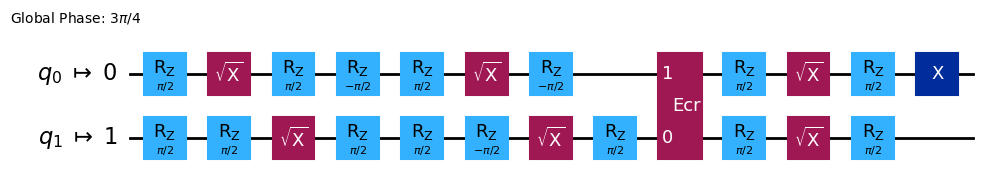

In [12]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
isa_circuit_0 = pm.run(qc)
 
isa_circuit_0.draw("mpl", idle_wires=False)

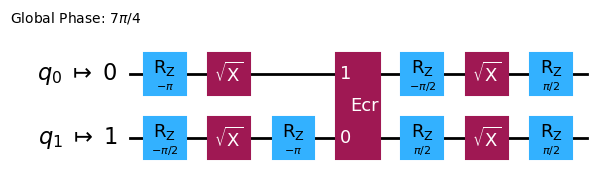

In [13]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit_1 = pm.run(qc)


isa_circuit_1.draw("mpl", idle_wires=False)

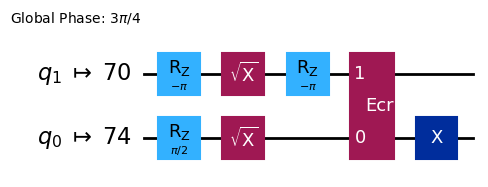

In [14]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit_2 = pm.run(qc)

isa_circuit_2.draw("mpl", idle_wires=False)

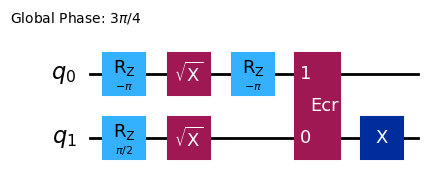

In [15]:
from qiskit.quantum_info import Statevector, DensityMatrix

qc_lv2 = QuantumCircuit(2, global_phase= 3* np.pi/4)

# Lista para guardar los estados
evolved_states_lv2 = []

# Función auxiliar para registrar el estado actual del circuito
def capture_state(circuit, state_list):
    state_list.append(Statevector(circuit))

#paso  0:
capture_state(qc_lv2, evolved_states_lv2)

# Paso 1
qc_lv2.rz(-np.pi, 0)
qc_lv2.rz(np.pi/2, 1)
capture_state(qc_lv2, evolved_states_lv2)

# Paso 2
qc_lv2.sx([0, 1])
capture_state(qc_lv2, evolved_states_lv2)

# Paso 3
qc_lv2.rz(-np.pi, 0)
capture_state(qc_lv2, evolved_states_lv2)

# Paso 4
qc_lv2.ecr(1, 0)
capture_state(qc_lv2, evolved_states_lv2)

# Paso 5
qc_lv2.x(1)
capture_state(qc_lv2, evolved_states_lv2)

# Dibujar circuito (opcional)
qc_lv2.draw('mpl')


In [16]:
def total_running_distance(evolved_states : list[Statevector]) -> float:
    """
    Computes the total running distance between the states in the list.
    evolved_states_lv2: list of Statevector objects
    return:
    total_running_distance: float, the total running distance
    """
    # Convert to numpy arrays
    evolved_states_numpy = [state.data for state in evolved_states]

    # Compute the total running distance
    total_running_distance = np.sum(
        [FS_distance(evolved_states_numpy[i], evolved_states_numpy[i + 1])
         for i in range(0, len(evolved_states_numpy) - 1)]
    )
    
    return total_running_distance


tot_run_dist_lv2 = total_running_distance(evolved_states_lv2)

print(f"Total running distance: {tot_run_dist_lv2:.5f}... ")  
    

Total running distance: 5.24264... 


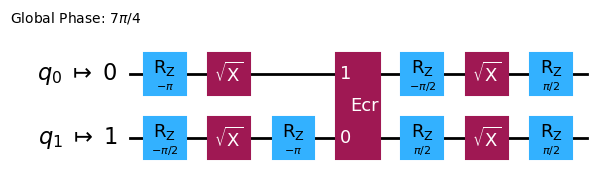

In [17]:
isa_circuit_1.draw('mpl', idle_wires=False)

Total running distance: 5.24264... 


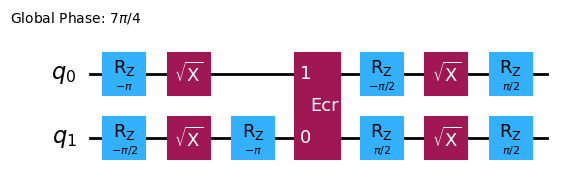

In [18]:
qc_lv1 = QuantumCircuit(2, global_phase= 7* np.pi/4)

evolved_states_lv1 = []

#paso 0
capture_state(qc_lv1, evolved_states_lv1)

# Paso 1
qc_lv1.rz(-np.pi, 0)
qc_lv1.rz(- np.pi/2, 1)
capture_state(qc_lv1, evolved_states_lv1)

# Paso 2
qc_lv1.sx([0, 1])
capture_state(qc_lv1, evolved_states_lv1)

# Paso 3
qc_lv1.rz(-np.pi, 1)
capture_state(qc_lv1, evolved_states_lv1)


# Paso 4
qc_lv1.ecr(1, 0)
capture_state(qc_lv1, evolved_states_lv1)

#paso 5:
qc_lv1.rz(-np.pi/2, 0)
qc_lv1.rz(np.pi/2, 1)
capture_state(qc_lv1, evolved_states_lv1)

# Paso 6
qc_lv1.sx([0, 1])
capture_state(qc_lv1, evolved_states_lv1)

#paso 7:
qc_lv1.rz(np.pi/2, 0)
qc_lv1.rz(np.pi/2, 1)
capture_state(qc_lv1, evolved_states_lv1)

tot_run_dist_lv1 = total_running_distance(evolved_states_lv1)
print(f"Total running distance: {tot_run_dist_lv1:.5f}... ")

qc_lv1.draw('mpl', idle_wires=False)

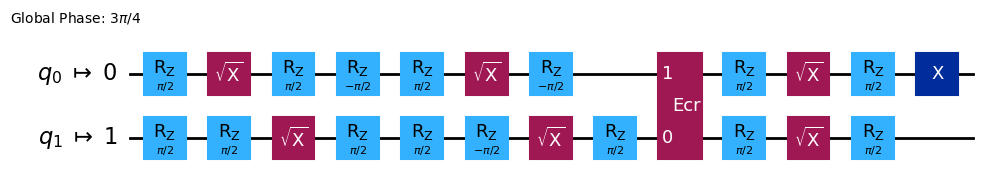

In [39]:
isa_circuit_0.draw('mpl', idle_wires=False)

In [41]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from IPython.display import display

#this is not good, but something to notice is that separate gateds have a shorter distance
#than the non local gates

#MAybe we can state that due to the fact that 
#if al gates are separable then the distance is equal toa ll the sum of these 
#separable states

dag = circuit_to_dag(isa_circuit_0)

for qubit in isa_circuit_0.qubits[2:]:
    dag.remove_qubits(qubit)

evolved_states_lv0 = []
qc_init_lv0 = QuantumCircuit(2, global_phase= 3* np.pi/4)
capture_state(qc_init_lv0, evolved_states_lv0)

for layer in dag.layers():
    layer_as_circ = dag_to_circuit(layer['graph'])
    #display(layer_as_circ.draw('mpl', idle_wires=False))
    capture_state(layer_as_circ, evolved_states_lv0)

tot_run_dist_lv0 = total_running_distance(evolved_states_lv0)

print(f"Total running distance: {tot_run_dist_lv0:.5f}... ")

Total running distance: 11.30411... 


/tmp/ipykernel_8321/2299438918.py:21: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circ = dag_to_circuit(layer['graph'])
/tmp/ipykernel_8321/2299438918.py:21: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circ = dag_to_circuit(layer['graph'])


/tmp/ipykernel_8321/1320420668.py:14: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circ = dag_to_circuit(layer['graph'])
/tmp/ipykernel_8321/1320420668.py:14: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circ = dag_to_circuit(layer['graph'])


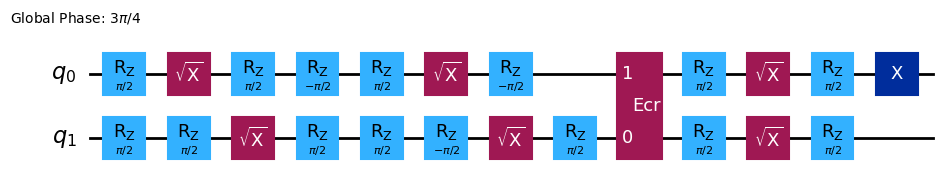

Total running distance: 11.71832... 


In [42]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from IPython.display import display

dag = circuit_to_dag(isa_circuit_0)

for qubit in isa_circuit_0.qubits[2:]:
    dag.remove_qubits(qubit)

evolved_states_lv0 = []
qc_init_lv0 = QuantumCircuit(2, global_phase= np.pi)
capture_state(qc_init_lv0, evolved_states_lv0)

for layer in dag.layers():
    layer_as_circ = dag_to_circuit(layer['graph'])
    qc_init_lv0.compose(layer_as_circ, inplace=True)
    capture_state(qc_init_lv0, evolved_states_lv0)


display(qc_init_lv0.draw('mpl'))
tot_run_dist_lv0 = total_running_distance(evolved_states_lv0)

print(f"Total running distance: {tot_run_dist_lv0:.5f}... ")

In [22]:

#this is redundant but its nice to see

"""
#################################################################

arr = geo_lenghts_zerozero_bell

# Encontrar el valor máximo, mínimo y sus índices
max_val = np.max(arr)
max_index = np.argmax(arr)

min_val = np.min(arr)
min_index = np.argmin(arr)

print(f" theta_lenght  entre |+0> y la curva geodesica: Valor máximo: {max_val}, Índice: {max_index}")
print(f"  theta_lenght  entre |+0> y la curva geodesica: Valor mínimo: {min_val}, Índice: {min_index} \n")

d_FS_circuit_ideal = distance_FS(ket_zerozero, ket_pluszero) + distance_FS(ket_pluszero, ket_bell)
geo_lenght_circuit_ideal = geodesic_lenght_pure_states(ket_zerozero, ket_pluszero) + geodesic_lenght_pure_states(ket_pluszero, ket_bell)


print(f'valor distancia circuito ideal d_FS: {d_FS_circuit_ideal:.5f}... ')
print(f'valor distancia circuito ideal geodesic: {geo_lenght_circuit_ideal:.5f}... ')

print(np.pi/2)
"""

'\n#################################################################\n\narr = geo_lenghts_zerozero_bell\n\n# Encontrar el valor máximo, mínimo y sus índices\nmax_val = np.max(arr)\nmax_index = np.argmax(arr)\n\nmin_val = np.min(arr)\nmin_index = np.argmin(arr)\n\nprint(f" theta_lenght  entre |+0> y la curva geodesica: Valor máximo: {max_val}, Índice: {max_index}")\nprint(f"  theta_lenght  entre |+0> y la curva geodesica: Valor mínimo: {min_val}, Índice: {min_index} \n")\n\nd_FS_circuit_ideal = distance_FS(ket_zerozero, ket_pluszero) + distance_FS(ket_pluszero, ket_bell)\ngeo_lenght_circuit_ideal = geodesic_lenght_pure_states(ket_zerozero, ket_pluszero) + geodesic_lenght_pure_states(ket_pluszero, ket_bell)\n\n\nprint(f\'valor distancia circuito ideal d_FS: {d_FS_circuit_ideal:.5f}... \')\nprint(f\'valor distancia circuito ideal geodesic: {geo_lenght_circuit_ideal:.5f}... \')\n\nprint(np.pi/2)\n'

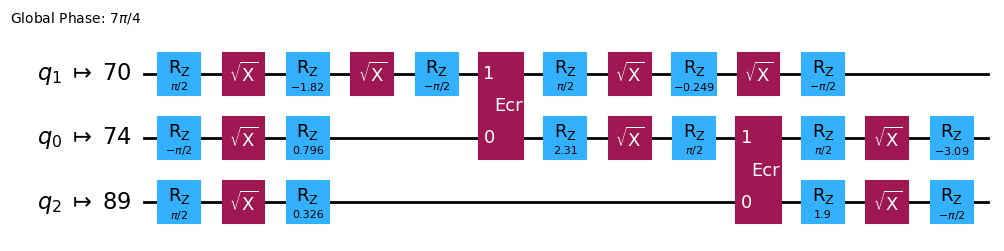

In [23]:
qc_GHZ = QuantumCircuit(3)
qc_GHZ.h(0)
qc_GHZ.cx(0, 1)
qc_GHZ.cx(0, 2)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

isa_circuit_GHZ = pm.run(qc_GHZ)
isa_circuit_GHZ.draw("mpl", idle_wires=False)

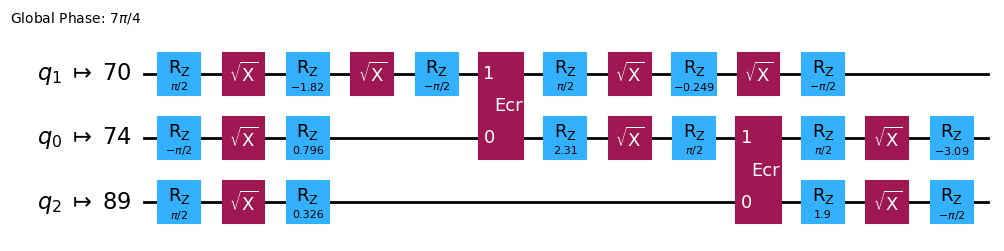

In [ ]:

qc_GHZ_2 = QuantumCircuit(3)
qc_GHZ_2.h(0)
qc_GHZ_2.cx(0, 1)
qc_GHZ_2.cx(0, 2)

isa_circuit_GHZ_2 = pm.run(qc_GHZ_2)
isa_circuit_GHZ_2.draw("mpl", idle_wires=False)

# To do:

-1) añadirlos al overleaf.
0) generalizar lo de las capas (Victor)
1) Realizar esto mismo de el calculo de las dist recorrida por el circuito con otras QPU (brisbane, y uan fake pero que considere las "fractional gates") (Victor)
2) " " " " con el estado GHZ, el estado W, y toda la familia de Bell y el ising de aquí [IBM Fractional Gates Guide](https://docs.quantum.ibm.com/guides/fractional-gates) (Herbert)
3) Usar hamiltoniano y explicar el tema de computación con pulsos para 1 y dos qubits (QuTIP) (Diego y Kevin)
4) Utilizar 3) para implementar esto de los micropulsos. (Todos los que quieran.)

